# 05tools_3: Model Explanability

Model explainability help understand model outputs = predictions.  There are two approaches here:
- Feature-Based Explanations
    - How much did each feature contribute to a specific prediction
    - Uses a baseline for comparison, usually based on the central value for each feature from the training data
    - Helpful for recognizing bias and finding areas for improvement
    - Read more about [feature attributions and methods](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview#feature_attributions)
    - Examples in [github.com/GoogleClouPlatform/vertex-ai-samples](https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/main/notebooks/official/explainable_ai)
- Example-Based Explanations
    - Return similar examples, neighbors, to help understand predictions
    - Along with prediction, get example from the source data that are most similar to the prediction to further understand "why?"
    
Vertex AI can serve explanations during online and batch predictions.  

### Prerequisites:
-  At least 1 of the notebooks in this series [05, 05a-05i]

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [34]:
REGION = 'us-central1'
DATANAME = 'fraud'
NOTEBOOK = '05tools_3'
SERIES = '05'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import aiplatform
from google.cloud import bigquery

import tensorflow as tf

from datetime import datetime
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [4]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client()

parameters:

In [5]:
BUCKET = PROJECT_ID
DIR = f"temp/{NOTEBOOK}"

In [6]:
# Give service account roles/storage.objectAdmin permissions
# Console > IAM > Select Account <projectnumber>-compute@developer.gserviceaccount.com > edit - give role
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

environment:

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Get Vertex AI Endpoint And Deployed Model

In [13]:
endpoints = aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{DATANAME}")
endpoint = endpoints[0]

In [14]:
endpoint.display_name

'05_fraud'

In [15]:
model = aiplatform.Model(
    model_name = endpoint.list_models()[0].model+f'@{endpoint.list_models()[0].model_version_id}'
)

In [16]:
model.display_name

'05_fraud'

In [17]:
model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/model_05_fraud@2'

In [18]:
model.uri

'gs://statmike-mlops-349915/fraud/models/05/20220815200908/model'

---
## Retrieve Records For Prediction & Explanation

In [19]:
n = 1000
pred = bq.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT {n}").to_dataframe()

In [20]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,32799,1.153477,-0.047859,1.358363,1.480620,-1.222598,-0.481690,-0.654461,0.128115,0.907095,...,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.0,0,e9d16028-4b41-4753-87ee-041d33642ae9,TEST
1,35483,1.286640,0.072917,0.212182,-0.269732,-0.283961,-0.663306,-0.016385,-0.120297,-0.135962,...,0.052674,0.076792,0.209208,0.847617,-0.086559,-0.008262,0.0,0,8b319d3a-2b2d-445b-a9a2-0da3d664ec2a,TEST
2,163935,1.961967,-0.247295,-1.751841,-0.268689,0.956431,0.707211,0.020675,0.189433,0.455055,...,0.186420,-1.621368,-0.131098,0.034276,-0.004909,-0.090859,0.0,0,788afb87-60aa-4482-8b48-c924bec634aa,TEST
3,30707,-0.964364,0.176372,2.464128,2.672539,0.145676,-0.152913,-0.591983,0.305066,-0.148034,...,-0.024200,0.365226,-0.745369,-0.060544,0.095692,0.217639,0.0,0,473d0936-1974-4ae8-ab70-230e7599bd3f,TEST


Remove columns not included as features in the model:

In [21]:
newobs = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')
#newobs[0]

In [22]:
len(newobs)

1000

---
## Feature-Based Explanations

In Vertex AI you [configure explanations](https://cloud.google.com/vertex-ai/docs/explainable-ai/configuring-explanations-feature-based) by providing an `explanationSpec`. For feature-based explanations this can be done when registering the model in the Model Registry.  You can also set, or override, the `explanationSpec` when deploying models to and endpoints or configuring batch predictions jobs.


### ExplanationSpec

From the [Python client for Vertex AI](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform), the `explanationSpec` is provided by two input parameters: `explanation_parameters` and `explanation_metadata`.  The parameters must be passed together and can be set (or overwritten):
- When registring the model in the Vertex AI Model Registry:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_upload
- When deploying a model the a Vertex AI Endpoint for online serving:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy
- When creating a Vertex AI Batch Prediciton Job:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.BatchPredictionJob#google_cloud_aiplatform_BatchPredictionJob_create



#### Explanation Parameters

The [Explanation Parameters](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/ExplanationSpec#ExplanationParameters) included setting the method of attribution along with associated parameters for the method.  A review of methods can be found [here](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview#compare-methods).

In [41]:
explanation_parameters = aiplatform.explain.ExplanationParameters({'integrated_gradients_attribution': {'step_count': 50}})
explanation_parameters

integrated_gradients_attribution {
  step_count: 50
}

#### Explanation Metadata

The [Explanation Metadata](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/ExplanationSpec#explanationmetadata) specifys the inputs metadata and outputs metadata.  For a TensorFlow model there is a tool for building the explanation metadata as used below:
- This is documented here: https://googleapis.dev/python/aiplatform/latest/index.html#explainable-ai-get-metadata


In [39]:
from google.cloud.aiplatform.explain.metadata.tf.v2 import saved_model_metadata_builder
builder = saved_model_metadata_builder.SavedModelMetadataBuilder(model.uri)
explanation_metadata = builder.get_metadata_protobuf()

In [40]:
explanation_metadata

inputs {
  key: "Amount"
  value {
    input_tensor_name: "Amount"
  }
}
inputs {
  key: "Time"
  value {
    input_tensor_name: "Time"
  }
}
inputs {
  key: "V1"
  value {
    input_tensor_name: "V1"
  }
}
inputs {
  key: "V10"
  value {
    input_tensor_name: "V10"
  }
}
inputs {
  key: "V11"
  value {
    input_tensor_name: "V11"
  }
}
inputs {
  key: "V12"
  value {
    input_tensor_name: "V12"
  }
}
inputs {
  key: "V13"
  value {
    input_tensor_name: "V13"
  }
}
inputs {
  key: "V14"
  value {
    input_tensor_name: "V14"
  }
}
inputs {
  key: "V15"
  value {
    input_tensor_name: "V15"
  }
}
inputs {
  key: "V16"
  value {
    input_tensor_name: "V16"
  }
}
inputs {
  key: "V17"
  value {
    input_tensor_name: "V17"
  }
}
inputs {
  key: "V18"
  value {
    input_tensor_name: "V18"
  }
}
inputs {
  key: "V19"
  value {
    input_tensor_name: "V19"
  }
}
inputs {
  key: "V2"
  value {
    input_tensor_name: "V2"
  }
}
inputs {
  key: "V20"
  value {
    input_tensor_name: "V2

### Create An Endpoint

In [35]:
endpoints = aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{DATANAME}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{DATANAME}",
        labels = {'notebook':f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952


In [36]:
endpoint.display_name

'05_fraud'

### Deploy Model To Endpoint
At the top of this notebook a current endpoint was used to retrieve the model that was used to create the explanations metadata.  In the cell below the same model is deployed again with 100% of traffic, this time with explanations metadata.  This demonstrates that the `explanationSpec` can be provided with the model upload to the Model Registry or at the point of model use for Endponts or Batch Prediction Jobs. 

In [45]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = model.display_name,
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_parameters = explanation_parameters,
    explanation_metadata = explanation_metadata
) 

Deploying Model projects/1026793852137/locations/us-central1/models/model_05_fraud to Endpoint : projects/1026793852137/locations/us-central1/endpoints/7252545822577917952
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952/operations/7105598636146294784
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952


### Remove Deployed Models without Traffic

In [46]:
for dmodel in endpoint.list_models():
    if dmodel.id in endpoint.traffic_split:
        print(f"Model {dmodel.display_name} has traffic = {endpoint.traffic_split[dmodel.id]}")
    else:
        endpoint.undeploy(deployed_model_id = dmodel.id)
        print(f"Undeployed {dmodel.display_name} version {dmodel.model_version_id} as it has no traffic.")

Model 05_fraud has traffic = 100
Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952/operations/1333672763717582848
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952
Undeployed 05_fraud version 2 as it has no traffic.
Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952/operations/4486192502876930048
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/7252545822577917952
Undeployed 05tools_3_fraud version 2 as it has no traffic.


In [47]:
endpoint.traffic_split

{'5929943285526167552': 100}

In [48]:
endpoint.list_models()

[id: "5929943285526167552"
 model: "projects/1026793852137/locations/us-central1/models/model_05_fraud"
 display_name: "05_fraud"
 create_time {
   seconds: 1660648599
   nanos: 28025000
 }
 dedicated_resources {
   machine_spec {
     machine_type: "n1-standard-4"
   }
   min_replica_count: 1
   max_replica_count: 1
 }
 explanation_spec {
   parameters {
     integrated_gradients_attribution {
       step_count: 50
     }
   }
   metadata {
     inputs {
       key: "Amount"
       value {
         input_tensor_name: "Amount"
       }
     }
     inputs {
       key: "Time"
       value {
         input_tensor_name: "Time"
       }
     }
     inputs {
       key: "V1"
       value {
         input_tensor_name: "V1"
       }
     }
     inputs {
       key: "V10"
       value {
         input_tensor_name: "V10"
       }
     }
     inputs {
       key: "V11"
       value {
         input_tensor_name: "V11"
       }
     }
     inputs {
       key: "V12"
       value {
         input_t

### Get Prediction: Python Client

In [49]:
instances = [json_format.ParseDict(newobs[0], Value())]

In [53]:
prediction = endpoint.predict(instances = instances)
prediction

Prediction(predictions=[[0.999868631, 0.000131341265]], deployed_model_id='5929943285526167552', model_version_id='2', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05_fraud', explanations=None)

In [54]:
prediction.predictions[0]

[0.999868631, 0.000131341265]

In [55]:
np.argmax(prediction.predictions[0])

0

### Get Prediction & Explanation: Python Client

In [56]:
explanation = endpoint.explain(instances = instances)

In [59]:
explanation.predictions[0]

[0.999868631, 0.000131341265]

In [72]:
print("attribution:")
print("baseline output:",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output:",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index:",explanation.explanations[0].attributions[0].output_index)
print("output_name:",explanation.explanations[0].attributions[0].output_name)
print("approximation error:",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output: 0.9982391595840454
instance output: 0.999868631362915
output_index: [0]
output_name: prediction_layer
approximation error: 0.0011341020580217219


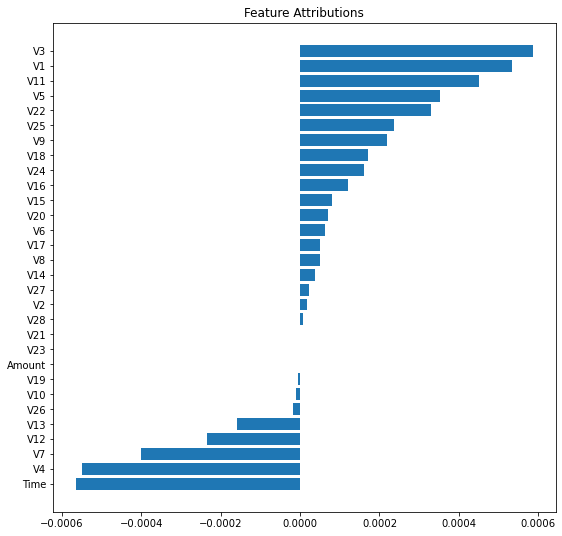

In [64]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
plt.title('Feature Attributions')
fig.show()

In the plot above, each bar represents the attribution for a feature, or how much the feature affected the change in the predicted value relative to the baseline value.

In [71]:
sum_attributions = 0
for k in explanation.explanations[0].attributions[0].feature_attributions:
    sum_attributions += explanation.explanations[0].attributions[0].feature_attributions[k]

print("baseline output:",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output:",explanation.explanations[0].attributions[0].instance_output_value)
print("Total Attribution:", sum_attributions)
print("instance - baseline:",explanation.explanations[0].attributions[0].instance_output_value-explanation.explanations[0].attributions[0].baseline_output_value)

baseline output: 0.9982391595840454
instance output: 0.999868631362915
Total Attribution: 0.0016276237802307042
instance - baseline: 0.001629471778869629


### Explainable AI SDK: Local Explanations
When using Vertex AI Workbench based user-manged notebooks you have access to the [Explainable AI SDK](https://github.com/GoogleCloudPlatform/explainable_ai_sdk).  This section demonstrates local explanations using the SDK.

This can be helpful for iterating on setting up explanations before deploying the model with `explanationSpec`:
- try different baselines
- setup vizualization settings for image models
- adjust parameters like steps (integrated gradients) or paths (sampled Shapley)

In [79]:
import explainable_ai_sdk
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

In [172]:
builder = SavedModelMetadataBuilder(model.uri)
builder.save_model_with_metadata(f'{DIR}/model')
!ls -l -R {DIR}/model

INFO:tensorflow:Assets written to: temp/05tools_3/model/assets


INFO:tensorflow:Assets written to: temp/05tools_3/model/assets


temp/05tools_3/model:
total 500
drwxr-xr-x 2 jupyter jupyter   4096 Aug 16 13:26 assets
-rw-r--r-- 1 jupyter jupyter   3541 Aug 16 15:29 explanation_metadata.json
-rw-r--r-- 1 jupyter jupyter 495718 Aug 16 15:29 saved_model.pb
drwxr-xr-x 2 jupyter jupyter   4096 Aug 16 15:29 variables

temp/05tools_3/model/assets:
total 0

temp/05tools_3/model/variables:
total 32
-rw-r--r-- 1 jupyter jupyter 27802 Aug 16 15:29 variables.data-00000-of-00001
-rw-r--r-- 1 jupyter jupyter  1449 Aug 16 15:29 variables.index


In [180]:
local_model = explainable_ai_sdk.load_model_from_local_path(
    model_path = f'{DIR}/model',
    config = explainable_ai_sdk.IntegratedGradientsConfig(step_count = 50)
)

In [222]:
type(local_model)

explainable_ai_sdk.model.local_model.LocalModel

In [184]:
newobs[0]

{'Time': 32799,
 'V1': 1.15347743766561,
 'V2': -0.0478588055804616,
 'V3': 1.35836288729212,
 'V4': 1.48062009487976,
 'V5': -1.22259808550513,
 'V6': -0.481689608379461,
 'V7': -0.6544612667240159,
 'V8': 0.128114599402494,
 'V9': 0.907094671648477,
 'V10': -0.0364175882073298,
 'V11': -0.659895142180526,
 'V12': -0.307334930019039,
 'V13': -1.3656343720183501,
 'V14': 0.035305634441467997,
 'V15': 0.7114399756440071,
 'V16': 0.25384340384905,
 'V17': -0.22283165732475999,
 'V18': 0.26559908021792394,
 'V19': -0.5970199308963089,
 'V20': -0.24568562944008399,
 'V21': 0.12551444308840598,
 'V22': 0.480049308608633,
 'V23': -0.0259637518455547,
 'V24': 0.7018428515999721,
 'V25': 0.41724451503333504,
 'V26': -0.257690694038964,
 'V27': 0.06011458360133701,
 'V28': 0.0353320583585812,
 'Amount': 0.0}

In [202]:
{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}

{'Time': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([32799.])>,
 'V1': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.15347744])>,
 'V2': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.04785881])>,
 'V3': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.35836289])>,
 'V4': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.48062009])>,
 'V5': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.22259809])>,
 'V6': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.48168961])>,
 'V7': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.65446127])>,
 'V8': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.1281146])>,
 'V9': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.90709467])>,
 'V10': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.03641759])>,
 'V11': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.65989514])>,
 'V12': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.30733493])>,
 'V13': <tf.Tensor: shape=(1,),

In [204]:
prediction = local_model.predict(instances = [{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}])
prediction

[{'prediction_layer': [0.999868631362915, 0.00013134126493241638]}]

In [205]:
explanation = local_model.explain(instances = [{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}])
explanation

In [206]:
explanation[0].feature_importance()

{'V27': 2.3187947590486147e-05,
 'V21': -1.857690534734502e-08,
 'V15': 7.92201972217299e-05,
 'V23': 1.1624036844182228e-08,
 'V26': -1.914645326905884e-05,
 'Time': -0.000568615912925452,
 'V17': 5.2168277761666104e-05,
 'V18': 0.00017379414930474013,
 'V16': 0.0001217191165778786,
 'V14': 3.695191480801441e-05,
 'V6': 6.410972855519503e-05,
 'V20': 6.839562411187217e-05,
 'V4': -0.0005530852940864861,
 'V28': 7.488383289455669e-06,
 'V3': 0.0005863337428309023,
 'V8': 5.04457057104446e-05,
 'V19': 1.9648902593871753e-07,
 'V9': 0.00021793397900182754,
 'Amount': 0.0,
 'V1': 0.0005379419308155775,
 'V10': -1.094575782190077e-05,
 'V12': -0.00023656767734792084,
 'V11': 0.00045407452853396535,
 'V25': 0.00023622048320248723,
 'V24': 0.00015644836821593344,
 'V22': 0.0003299017553217709,
 'V13': -0.00015876580437179655,
 'V5': 0.00035706331254914403,
 'V2': 1.7390046195941977e-05,
 'V7': -0.0004042212967760861}

In [207]:
explanation[0].as_tensors()

{'V27': array([2.3187948e-05], dtype=float32),
 'V21': array([-1.8576905e-08], dtype=float32),
 'V15': array([7.92202e-05], dtype=float32),
 'V23': array([1.1624037e-08], dtype=float32),
 'V26': array([-1.9146453e-05], dtype=float32),
 'Time': array([-0.00056862], dtype=float32),
 'V17': array([5.2168278e-05], dtype=float32),
 'V18': array([0.00017379], dtype=float32),
 'V16': array([0.00012172], dtype=float32),
 'V14': array([3.6951915e-05], dtype=float32),
 'V6': array([6.410973e-05], dtype=float32),
 'V20': array([6.8395624e-05], dtype=float32),
 'V4': array([-0.00055309], dtype=float32),
 'V28': array([7.4883833e-06], dtype=float32),
 'V3': array([0.00058633], dtype=float32),
 'V8': array([5.0445706e-05], dtype=float32),
 'V19': array([1.9648903e-07], dtype=float32),
 'V9': array([0.00021793], dtype=float32),
 'Amount': array([-0.], dtype=float32),
 'V1': array([0.00053794], dtype=float32),
 'V10': array([-1.0945758e-05], dtype=float32),
 'V12': array([-0.00023657], dtype=float32),

Label Index 0
Example Score: 0.9999
Baseline Score: 0.9982
Approximation Error: 0.0060


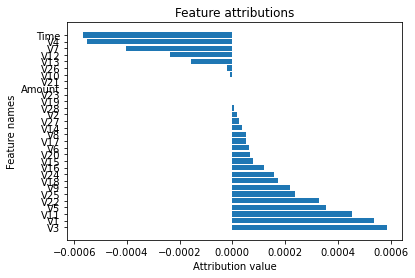

In [208]:
explanation[0].visualize_attributions()

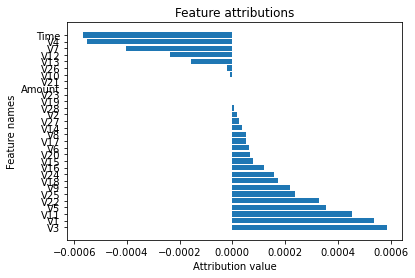

In [211]:
explanation[0].visualize_top_k_features(k=len(newobs[0]))

### Explainable AI SDK With Vertex AI Endpoints
The features of the Explainable AI SDK are also useful for Vertex AI Endpoints.  The example below shows using the SDK with a Vertex AI Endpoint, the one setup in this notebook with `explanationSpec`.

In [213]:
vertex_explain = explainable_ai_sdk.load_model_from_vertex(
    project = PROJECT_ID,
    region = REGION,
    endpoint_id = endpoint.resource_name.split('/')[-1]
)

In [214]:
prediction = vertex_explain.predict(instances = [newobs[0]])
prediction

{'predictions': [[0.999868631, 0.000131341265]],
 'deployedModelId': '5929943285526167552',
 'model': 'projects/1026793852137/locations/us-central1/models/model_05_fraud',
 'modelDisplayName': '05_fraud',
 'modelVersionId': '2'}

In [215]:
explanation = vertex_explain.explain(instances = [newobs[0]])

In [216]:
explanation[0].feature_importance()

{'V6': 6.32305570944756e-05,
 'Time': -0.0005644056170757296,
 'V3': 0.0005862443876218519,
 'V12': -0.0002338219884710284,
 'V16': 0.0001219742939404552,
 'V27': 2.296230569430825e-05,
 'V1': 0.0005346872354193361,
 'V19': -4.391112084627638e-06,
 'V13': -0.0001578577202080322,
 'V18': 0.0001716385820340425,
 'V11': 0.0004518153387045784,
 'V10': -1.111432975064325e-05,
 'V4': -0.0005487667499262989,
 'V28': 7.082115204084696e-06,
 'V20': 6.938063768356484e-05,
 'V9': 0.0002194917776004117,
 'V8': 5.062969851832529e-05,
 'V22': 0.0003306545735255082,
 'V23': 1.766099258222833e-07,
 'V17': 5.140912391432412e-05,
 'V21': 1.949838204872482e-07,
 'V24': 0.0001621057369752206,
 'V26': -1.843766157289843e-05,
 'V2': 1.748263595768682e-05,
 'V14': 3.670380091659775e-05,
 'V15': 7.979581647602168e-05,
 'V7': -0.0004003349897527289,
 'V5': 0.000352598851561832,
 'V25': 0.0002364948864837564}

In [217]:
explanation[0].as_tensors()

{'V6': array(6.32305571e-05),
 'Time': array(-0.00056441),
 'V3': array(0.00058624),
 'V12': array(-0.00023382),
 'V16': array(0.00012197),
 'V27': array(2.29623057e-05),
 'V1': array(0.00053469),
 'V19': array(-4.39111208e-06),
 'V13': array(-0.00015786),
 'V18': array(0.00017164),
 'V11': array(0.00045182),
 'V10': array(-1.11143298e-05),
 'V4': array(-0.00054877),
 'V28': array(7.0821152e-06),
 'V20': array(6.93806377e-05),
 'V9': array(0.00021949),
 'V8': array(5.06296985e-05),
 'V22': array(0.00033065),
 'V23': array(1.76609926e-07),
 'V17': array(5.14091239e-05),
 'V21': array(1.9498382e-07),
 'V24': array(0.00016211),
 'V26': array(-1.84376616e-05),
 'V2': array(1.7482636e-05),
 'V14': array(3.67038009e-05),
 'V15': array(7.97958165e-05),
 'V7': array(-0.00040033),
 'V5': array(0.0003526),
 'V25': array(0.00023649)}

In [218]:
explanation[0].visualize_attributions()

Label Index [0]
Example Score: 0.9999
Baseline Score: 0.9982
Approximation Error: 0.0011


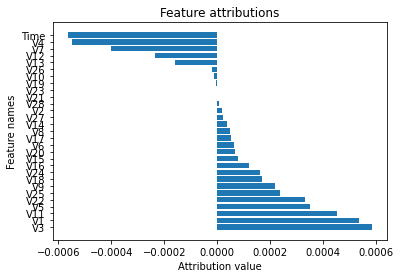

In [219]:
explanation[0].visualize_top_k_features(k=len(newobs[0]))

---
## Example-Based Explanations